##Load Data

In [20]:
!nvidia-smi #py 3.10.11

ERROR: Option #py is not recognized. Please run 'nvidia-smi -h'.



In [21]:
#Count data
import os

# Define the paths to the directories
train_dir = "./../data/train/"
test_dir = "./../data/test/"

categories = [
    "ALGAL_LEAF_SPOT",
    "ALLOCARIDARA_ATTACK",
    "HEALTHY_LEAF",
    "LEAF_BLIGHT",
    "PHOMOPSIS_LEAF_SPOT"
]

print("--- Training Set File Counts ---")
for category in categories:
    dir_path = os.path.join(train_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

print("\n--- Test Set File Counts ---")
for category in categories:
    dir_path = os.path.join(test_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

--- Training Set File Counts ---
Number of files in ./../data/train/ALGAL_LEAF_SPOT: 632
Number of files in ./../data/train/ALLOCARIDARA_ATTACK: 787
Number of files in ./../data/train/HEALTHY_LEAF: 841
Number of files in ./../data/train/LEAF_BLIGHT: 808
Number of files in ./../data/train/PHOMOPSIS_LEAF_SPOT: 757

--- Test Set File Counts ---
Number of files in ./../data/test/ALGAL_LEAF_SPOT: 101
Number of files in ./../data/test/ALLOCARIDARA_ATTACK: 126
Number of files in ./../data/test/HEALTHY_LEAF: 135
Number of files in ./../data/test/LEAF_BLIGHT: 129
Number of files in ./../data/test/PHOMOPSIS_LEAF_SPOT: 121


#Install Timm

In [22]:
# Install Timm (Need to restart the runtime after finish install )
#pip install git+https://github.com/rwightman/pytorch-image-models.git
#%pip install lightning transformers datasets evaluate pillow 

In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import StratifiedKFold,KFold

from lightning.fabric import Fabric

from copy import copy

import shutil
import torchvision.transforms as transforms

from sklearn.utils.class_weight import compute_class_weight
from torchvision import datasets

##visualization Model

In [24]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

In [25]:
# Select model (List of available is shown above)
mobilenetv3_large_100 = "hf_hub:timm/mobilenetv3_large_100.miil_in21k_ft_in1k"
mobilenetv3_large_100_model= timm.create_model(mobilenetv3_large_100, pretrained=True, num_classes=5)
# Print a summary using torchinfo (uncomment for actual output)
summary(model=mobilenetv3_large_100_model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                          [16, 3, 224, 224]    [16, 5]              --                   True
├─Conv2d (conv_stem)                               [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
├─BatchNormAct2d (bn1)                             [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    └─Identity (drop)                             [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─Hardswish (act)                             [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
├─Sequential (blocks)                              [16, 16, 112, 112]   [16, 960, 7, 7]      --                   True
│    └─Sequential (0)                              [16, 16, 112, 112]   [16, 16, 112, 112]   --                   True
│    │    └─DepthwiseSeparableConv (0)         

In [26]:
# Transform image data based on ImageNet's mean and std
data_transforms = { # เปลี่ยนชื่อตัวแปรเป็น data_transforms
    "train": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
}

In [27]:
dataset = datasets.ImageFolder(root=train_dir,
                               transform=data_transforms["train"], 
                               target_transform=None)

In [28]:
dataset.class_to_idx

{'ALGAL_LEAF_SPOT': 0,
 'ALLOCARIDARA_ATTACK': 1,
 'HEALTHY_LEAF': 2,
 'LEAF_BLIGHT': 3,
 'PHOMOPSIS_LEAF_SPOT': 4}

In [29]:
len(dataset)

3825

In [30]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
#Select Model
model_name = "hf_hub:timm/mobilenetv3_large_100.miil_in21k_ft_in1k"

In [32]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("accuracy")

In [33]:
# Cross validation
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [34]:
# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 16
eval_batch_size = 8
num_accumulate = 1

In [35]:
torch.set_float32_matmul_precision('high')
#fabric = Fabric(accelerator="cuda", precision="16-mixed")
fabric = Fabric(accelerator="gpu", devices=1, precision="16-mixed")
fabric.launch()

Using 16-bit Automatic Mixed Precision (AMP)


In [36]:
import time

In [ ]:
%%time
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of {k_splits}")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=5)


    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=5e-4)
    # optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)    # update the slow weight every k steps
                                                                   # update the optimizer by combine slow weight and fast weight * alpha

    model, optimizer = fabric.setup(model, optimizer)

    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    train_dataloader, val_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
        "best_val_loss": 999,
    }

    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        num_updates = epoch * len(train_dataloader)

        ### === Train Loop === ###
        ## Time
        s1 = time.time()

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            # inputs = {k: v.to(device) for k,v in inputs.items()}
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            fabric.backward(loss)

            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            # ============================= #

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
        ### ==================== ###

        # optimizer.sync_lookahead()              # Sync slow weight and fast weight
        scheduler.step(epoch + 1)

        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                # inputs = {k: v.to(device) for k,v in inputs.items()}
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###
        ## Time train finish
        s2 = time.time()
        elapsed_time = s2 - s1


        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets)["accuracy"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets)["accuracy"]

        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)

        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))

        if metric_val > info["best_metric_val"]:
        # if info["val_loss"][-1] < info["best_val_loss"]:
            print("New Best Score!")
            # print("New Best Val Loss")
            info["best_metric_val"] = metric_val
            # info["best_val_loss"] = info["val_loss"][-1]
            torch.save(model, f"mobilenetv3_large_100_checkpoint_fold{fold}.pt")

        print(f"Using time of Fold: {fold} | Epoch: {epoch} | {elapsed_time} second ")
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

    # save all best metric val
    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 0 | 45.672115087509155 second 
{'metric_train': [0.6607843137254902], 'metric_val': [0.8326797385620915], 'train_loss': [np.float64(1.9566004051109)], 'val_loss': [np.float64(0.62715644050013)], 'best_metric_val': 0.8326797385620915, 'best_val_loss': 999}
Fold: 0 | Epoch: 0 | Metric: 0.8326797385620915 | Training Loss: 1.9566004051109 | Validation Loss: 0.62715644050013


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 1 | 40.49234890937805 second 
{'metric_train': [0.6607843137254902, 0.8931372549019608], 'metric_val': [0.8326797385620915, 0.8915032679738563], 'train_loss': [np.float64(1.9566004051109), np.float64(0.38231430503098335)], 'val_loss': [np.float64(0.62715644050013), np.float64(0.35810988876145683)], 'best_metric_val': 0.8915032679738563, 'best_val_loss': 999}
Fold: 0 | Epoch: 1 | Metric: 0.8915032679738563 | Training Loss: 0.38231430503098335 | Validation Loss: 0.35810988876145683


  0%|          | 0/192 [00:00<?, ?it/s]

In [ ]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [ ]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"mobilenetv3_large_100_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

FileNotFoundError: [Errno 2] No such file or directory: 'mobilenetv3_large_100_checkpoint_fold0.pt'

In [ ]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

###Verification by sepreate data

In [ ]:
# Making Dataset
from torchvision import datasets
test_dataset = datasets.ImageFolder(root=test_dir,
                               transform=data_transforms["test"], # ใช้ data_transforms แทน
                               target_transform=None)# transforms to perform on labels (if necessary)

In [ ]:
len(test_dataset)

890

In [ ]:
# Making test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
test_dataset.classes

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [ ]:
len(test_dataloader)

112

Evaluating Fold 0:   0%|          | 0/112 [00:00<?, ?it/s]


--- Results for Fold: 0 ---


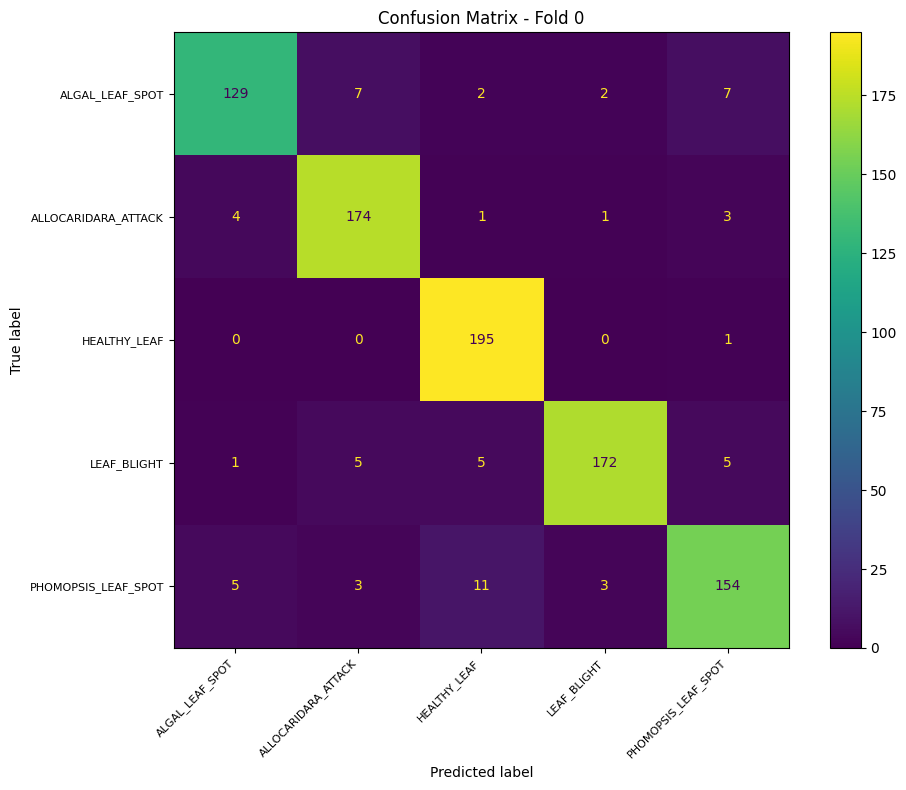

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.93      0.88      0.90       147
ALLOCARIDARA_ATTACK       0.92      0.95      0.94       183
       HEALTHY_LEAF       0.91      0.99      0.95       196
        LEAF_BLIGHT       0.97      0.91      0.94       188
PHOMOPSIS_LEAF_SPOT       0.91      0.88      0.89       176

           accuracy                           0.93       890
          macro avg       0.93      0.92      0.92       890
       weighted avg       0.93      0.93      0.93       890

--------------------------------------------------


Evaluating Fold 1:   0%|          | 0/112 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- Results for Fold: 1 ---


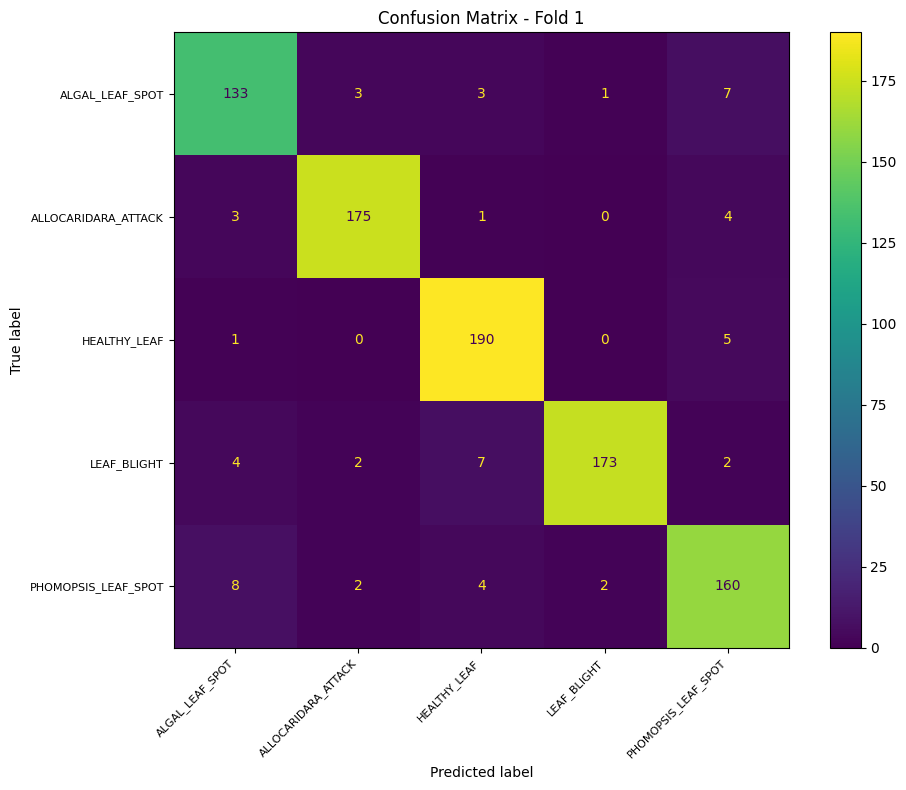

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.89      0.90      0.90       147
ALLOCARIDARA_ATTACK       0.96      0.96      0.96       183
       HEALTHY_LEAF       0.93      0.97      0.95       196
        LEAF_BLIGHT       0.98      0.92      0.95       188
PHOMOPSIS_LEAF_SPOT       0.90      0.91      0.90       176

           accuracy                           0.93       890
          macro avg       0.93      0.93      0.93       890
       weighted avg       0.93      0.93      0.93       890

--------------------------------------------------


Evaluating Fold 2:   0%|          | 0/112 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- Results for Fold: 2 ---


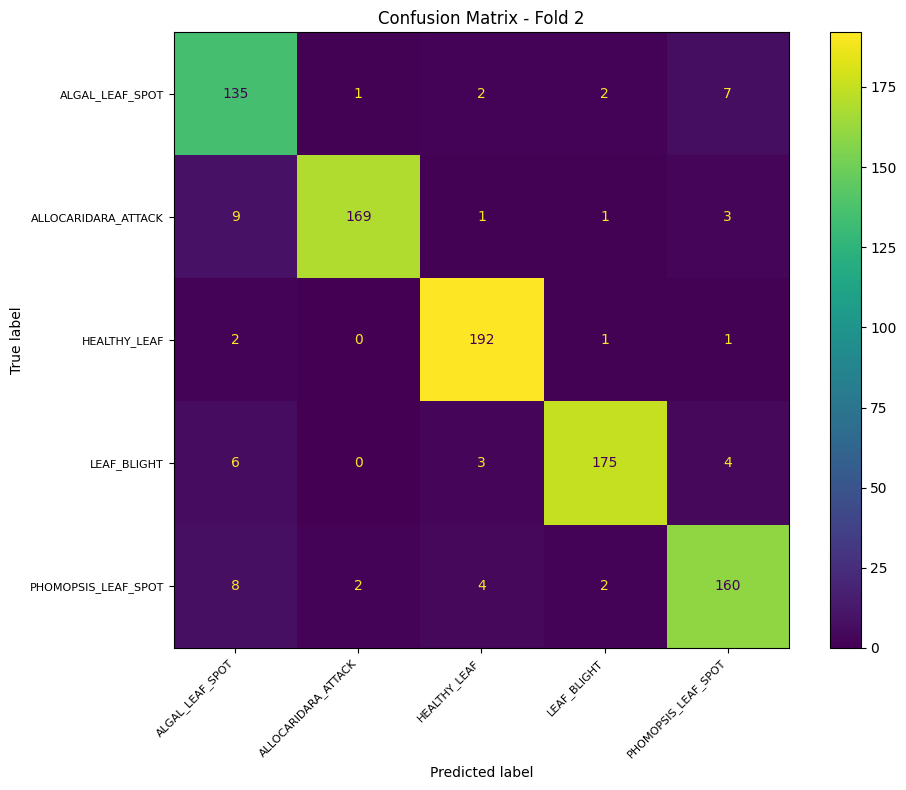

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.84      0.92      0.88       147
ALLOCARIDARA_ATTACK       0.98      0.92      0.95       183
       HEALTHY_LEAF       0.95      0.98      0.96       196
        LEAF_BLIGHT       0.97      0.93      0.95       188
PHOMOPSIS_LEAF_SPOT       0.91      0.91      0.91       176

           accuracy                           0.93       890
          macro avg       0.93      0.93      0.93       890
       weighted avg       0.94      0.93      0.93       890

--------------------------------------------------


Evaluating Fold 3:   0%|          | 0/112 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- Results for Fold: 3 ---


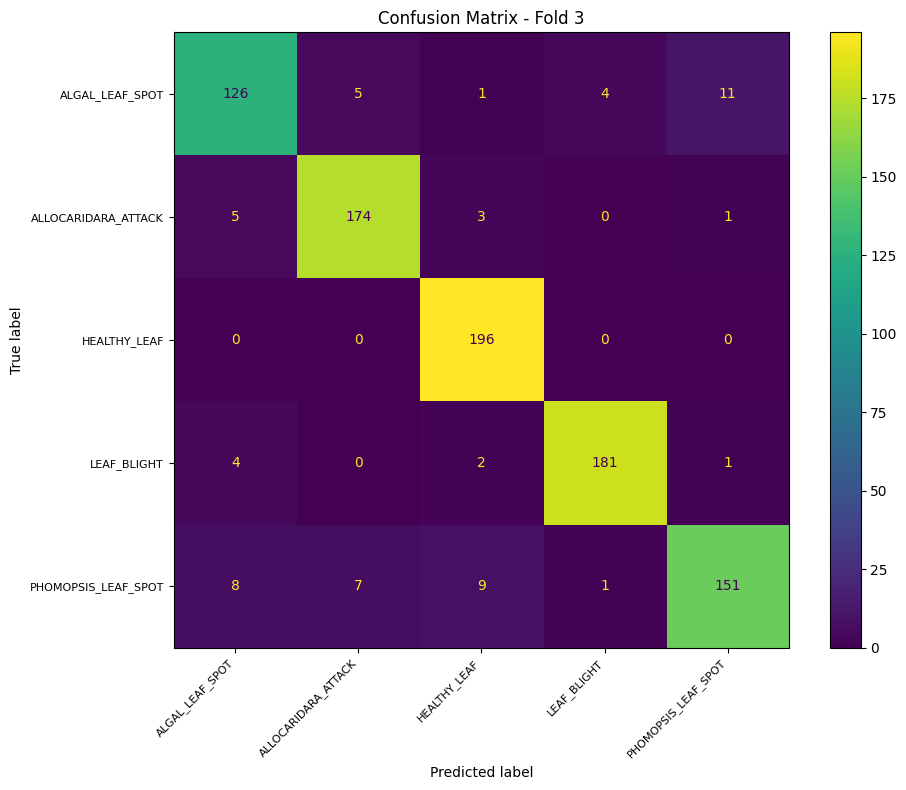

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.88      0.86      0.87       147
ALLOCARIDARA_ATTACK       0.94      0.95      0.94       183
       HEALTHY_LEAF       0.93      1.00      0.96       196
        LEAF_BLIGHT       0.97      0.96      0.97       188
PHOMOPSIS_LEAF_SPOT       0.92      0.86      0.89       176

           accuracy                           0.93       890
          macro avg       0.93      0.93      0.93       890
       weighted avg       0.93      0.93      0.93       890

--------------------------------------------------


Evaluating Fold 4:   0%|          | 0/112 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



--- Results for Fold: 4 ---


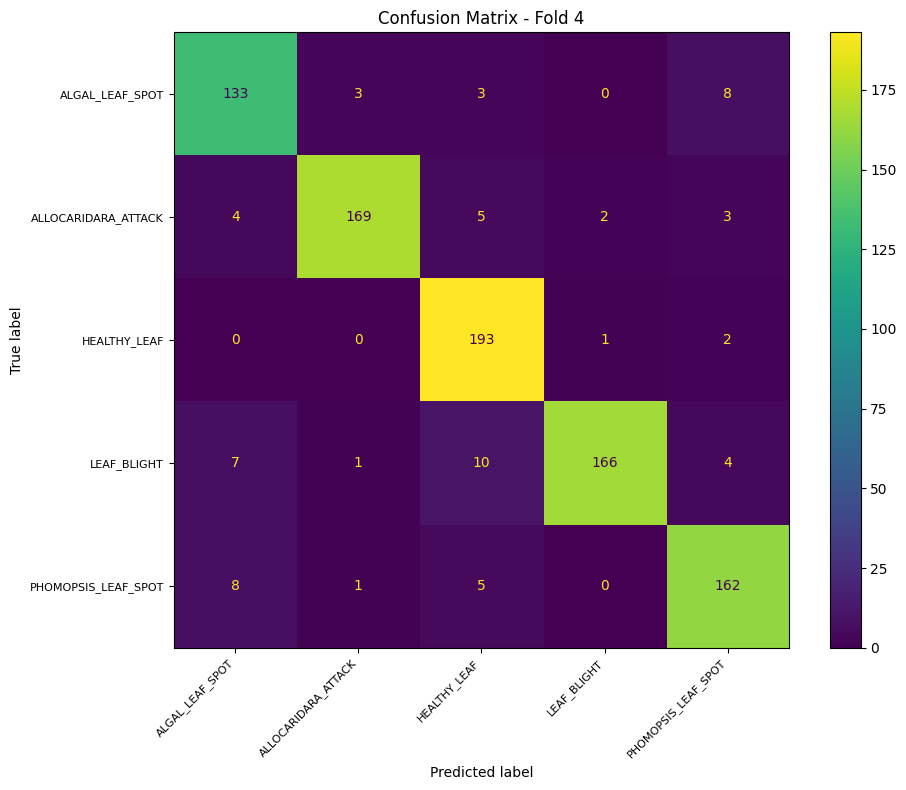

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.88      0.90      0.89       147
ALLOCARIDARA_ATTACK       0.97      0.92      0.95       183
       HEALTHY_LEAF       0.89      0.98      0.94       196
        LEAF_BLIGHT       0.98      0.88      0.93       188
PHOMOPSIS_LEAF_SPOT       0.91      0.92      0.91       176

           accuracy                           0.92       890
          macro avg       0.93      0.92      0.92       890
       weighted avg       0.93      0.92      0.92       890

--------------------------------------------------


In [ ]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"mobilenetv3_large_100_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

##Visualization train model result

In [ ]:
## Making Pridcition return class & prob
from typing import List, Tuple

from PIL import Image
def pred_class(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: T = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    classname =  class_names[target_image_pred_label]
    prob = target_image_pred_probs.max().cpu().numpy()

    return classname , prob

In [ ]:
##Load some model
loaded_model = torch.load('/content/mobilenetv3_large_100_checkpoint_fold0.pt', weights_only=False)

##Train data visulization

In [ ]:
#Making df for random
import os
import pandas as pd
from PIL import Image

# create an empty list to store image paths
image_paths = []

# loop through each subfolder in the "Image" directory
for root, dirs, files in os.walk('/content/test'):
    for subfolder_name in dirs:
        # get the path to the subfolder
        subfolder_path = os.path.join(root, subfolder_name)
        # loop through each file in the subfolder
        for filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, filename)
            image_paths.append((image_path, subfolder_name))

# create a DataFrame from the list of image paths
df = pd.DataFrame(image_paths, columns=['path', 'subfolder_name'])


In [ ]:
df.head()

,path,subfolder_name


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



def sample_picture(df=df,random_state=None):
    # Sample 20 random rows from the DataFrame
    sample_df = df.sample(20, random_state=random_state).copy()
    sample_df = sample_df.reset_index(drop=True)
    # Define the grid layout for displaying the images
    num_rows = 4
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
    fig.tight_layout(pad=5.0)

    # Iterate over the sampled rows and display the images in the grid
    for i, row in sample_df.iterrows():
        img = Image.open(row['path'])

        # Prediction
        pred_name , prob = pred_class(model=loaded_model,image_path=row['path'],
                   class_names = classname,
                   transform=transforms["test"])

        row_idx = i // num_cols
        col_idx = i % num_cols
        axs[row_idx, col_idx].imshow(img)
        axs[row_idx, col_idx].axis('on')
        axs[row_idx, col_idx].set_title(row['subfolder_name'] + ': \nPredict:' + pred_name + '\nProb:'+ str(prob.round(decimals=2)) )

        # prediction


    plt.show()

In [ ]:
sample_picture()

AttributeError: 'ImageFolder' object has no attribute 'sample'

In [ ]:
sample_picture()

In [ ]:
sample_picture()

In [ ]:
sample_picture()

In [ ]:
sample_picture()

In [ ]:
sample_picture()

## Outsite data testing

In [ ]:
!wget https://universe.roboflow.com/ds/fx3tNSqjNJ?key=N4VBuJEAJf

In [ ]:
!unzip /content/fx3tNSqjNJ?key=N4VBuJEAJf